In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(1, '../scripts/')
from utils import *
from processing import *
import pickle
from hyperopt import tpe, fmin, hp
from hyperopt.pyll.base import scope
from sklearn.decomposition import PCA
import shap
import torch
from torch import nn 
import torch.nn.functional as F
from skorch import NeuralNetClassifier

In [2]:
lead = 6
obs = 1

## Loading Data

In [3]:
# Original data
data = pd.read_csv("../csv/relative_{}hr_lead_{}hr_obs_data/relative_{}hr_lead_{}hr_obs_dataset_no_pts.csv".format(lead, obs, lead, obs), low_memory=False)
data["mv_duration_ratio"] = data["mv_duration"]/data["LOS"]
data

,PatientStayID,Class,LOS,Age,APACHEIVscore,APACHEIVaScore,UrgentAdmission,AdmissionCategory,NumBeds,TeachingStatus,...,comorbidity_drug,comorbidity_depre,last_24hr_urine,tranfuse_rbc,tranfuse_plasma,tranfuse_platelet,dialysis,surgical,mv_duration,mv_duration_ratio
0,150934,1,466.0,69.0,78.0,78.0,1.0,4.0,2.0,0,...,0.0,0.0,NaN,0,0,0,1,0,0.0,0.000000
1,151708,1,1647.0,79.0,38.0,38.0,1.0,4.0,4.0,1,...,0.0,0.0,300.0,0,0,0,0,0,0.0,0.000000
2,152171,1,2020.0,84.0,38.0,38.0,0.0,4.0,2.0,0,...,0.0,0.0,NaN,0,0,0,0,1,0.0,0.000000
3,155126,1,3161.0,71.0,65.0,65.0,0.0,4.0,4.0,1,...,0.0,0.0,NaN,1,0,0,0,1,117.0,0.037014
4,156970,1,17639.0,56.0,32.0,32.0,1.0,4.0,4.0,1,...,0.0,0.0,2345.0,0,0,0,0,0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21429,3352487,0,360.0,60.0,45.0,45.0,0.0,4.0,4.0,0,...,NaN,NaN,1945.0,0,0,0,0,1,0.0,0.000000
21430,3352563,0,930.0,34.0,54.0,54.0,1.0,4.0,2.0,0,...,0.0,0.0,1555.0,0,0,0,0,0,0.0,0.000000
21431,3352747,0,886.0,30.0,31.0,31.0,1.0,4.0,4.0,0,...,0.0,0.0,1800.0,0,0,0,0,0,0.0,0.000000
21432,3353044,0,3038.0,52.0,41.0,41.0,1.0,4.0,2.0,0,...,0.0,0.0,2890.0,0,0,0,0,0,0.0,0.000000


In [4]:
# Validation Set
validation = pd.read_csv("../csv/relative_{}hr_lead_{}hr_obs_data/relative_{}hr_lead_{}hr_obs_validation/relative_{}hr_lead_{}hr_obs_validation_data_set.csv".format(lead, obs, lead, obs, lead, obs))
validation["mv_duration_ratio"] = validation["mv_duration"]/validation["LOS"]
validation.drop(columns=['HistLiverFail', 'HistMetastases', 'HistLymphoma', 'HistLeukemia', 'HistAIDS', 'coma', "Ethnicity"], inplace=True)

In [5]:
# Mismatch in Features, features in original that aren't in validation
for col in data.columns:
    if col not in validation.columns:
        print(col)

APACHEIVaScore
AdmitHeight
AdmitSource
UnitAdmitSource
relative_6hr_lead_1hr_obsAcetaminophen
last_bedside glucose
diff_bedside glucose
last_MPV
diff_MPV
last_-polys
diff_-polys
ventilator


In [6]:
# Mismatch in Features, features in validation that aren't in original
for col in validation.columns:
    if col not in data.columns:
        print(col)

## Processing

In [7]:
data = process_all(data)
for col in data.columns:
    if missing_data(data, col)[0] > 0.2*missing_data(data,col)[1]:
        data.drop(labels=[col], axis=1, inplace=True)

common_imputation= ["Gender", "UrgentAdmission", "TeachingStatus"]
for col in data.columns:
    if col.startswith("comorbidity_") or col.startswith("Hist"):
        common_imputation.append(col)
one_hot_removal = []
remove = ["APACHEIVaScore", "relative_{}hr_lead_{}hr_obsHaloperidol".format(lead, obs), "relative_{}hr_lead_{}hr_obsPrecedex".format(lead, obs), "ventilator", "vented", "UnitAdmitSource_Missing", "vasopressors"]#, "mean_motor_GCS", 

exceptions = []# ["UrgentAdmission"]

mean_imputation = data.columns
mean_imputation = mean_imputation.drop(common_imputation)
mean_imputation = mean_imputation.drop(one_hot_removal)
mean_imputation = mean_imputation.drop(remove)
mean_imputation = mean_imputation.drop(exceptions)
mean_imputation = mean_imputation.tolist()


for col in data.columns:
    if col.startswith("count_"):
        data[col] = data[col].fillna(0)
    if col.startswith("diff_"):
        data[col] = data[col].fillna(0)

from sklearn.impute import SimpleImputer
data.drop(remove, axis=1, inplace = True)
imp_mean = SimpleImputer(strategy='mean')
imp_mean.fit(data[mean_imputation])
data[mean_imputation] = imp_mean.transform(data[mean_imputation])
imp_freq = SimpleImputer(strategy='most_frequent')
imp_freq.fit(data[common_imputation])
data[common_imputation] = imp_freq.transform(data[common_imputation])
data.dropna(inplace = True)
data

,PatientStayID,Class,LOS,Age,APACHEIVscore,UrgentAdmission,NumBeds,TeachingStatus,Gender,AdmitHeight,...,UnitAdmitSource_DirectAdmit,UnitAdmitSource_EmergencyDep,UnitAdmitSource_Floor,UnitAdmitSource_ICU,UnitAdmitSource_OR,UnitAdmitSource_Other,UnitAdmitSource_OtherHospital,UnitAdmitSource_PACU,UnitAdmitSource_SDU,TimeOfDay
0,150934.0,1.0,466.0,69.0,78.0,1.0,2.0,0.0,1.0,152.4,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70860.0
1,151708.0,1.0,1647.0,79.0,38.0,1.0,4.0,1.0,0.0,175.3,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78480.0
2,152171.0,1.0,2020.0,84.0,38.0,0.0,2.0,0.0,1.0,165.1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3720.0
3,155126.0,1.0,3161.0,71.0,65.0,0.0,4.0,1.0,0.0,165.1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,58260.0
4,156970.0,1.0,17639.0,56.0,32.0,1.0,4.0,1.0,0.0,167.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7020.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21429,3352487.0,0.0,360.0,60.0,45.0,0.0,4.0,0.0,1.0,168.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,27180.0
21430,3352563.0,0.0,930.0,34.0,54.0,1.0,2.0,0.0,1.0,172.7,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,960.0
21431,3352747.0,0.0,886.0,30.0,31.0,1.0,4.0,0.0,0.0,167.6,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25200.0
21432,3353044.0,0.0,3038.0,52.0,41.0,1.0,2.0,0.0,0.0,175.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1020.0


In [8]:
validation = process_all(validation)

In [9]:
for col in validation.columns:
    print(col)
    print(missing_data(validation, col))

PatientStayID
(0, 5926)
Class
(0, 5926)
LOS
(0, 5926)
Gender
(0, 5926)
AdmitWeight
(67, 5926)
TeachingStatus
(0, 5926)
Age
(0, 5926)
UrgentAdmission
(0, 5926)
NumBeds
(0, 5926)
APACHEIVscore
(0, 5926)
HistAICD
(65, 5926)
HistAngina
(65, 5926)
HistAplasticAnemia
(65, 5926)
HistArrythmia
(65, 5926)
HistAsthma
(65, 5926)
HistCABG
(65, 5926)
HistCancer
(65, 5926)
HistChemotherapy
(65, 5926)
HistCHF
(65, 5926)
HistCirrhosis
(65, 5926)
HistClottingDisorder
(65, 5926)
HistCOPD
(65, 5926)
HistCushing
(65, 5926)
HistDementia
(65, 5926)
Histdiabetes
(65, 5926)
HistHeartTransp
(65, 5926)
HistHemolyticAnemia
(65, 5926)
HistHypercalcemia
(65, 5926)
HistHypercoagulableCondition
(65, 5926)
HistHypersplenism
(65, 5926)
HistHypertension
(65, 5926)
Histhyperthyroid
(65, 5926)
Histhypothyroid
(65, 5926)
HistImmuneSuppr
(65, 5926)
HistIntracranialMass
(65, 5926)
HistLiverTransp
(65, 5926)
HistLungTransp
(65, 5926)
HistMI
(65, 5926)
HistMyeloproliferativeDisease
(65, 5926)
HistNeurogenicBladd
(65, 5926)
Hi

In [10]:
# Mismatch in Features, features in original that aren't in validation
for col in data.columns:
    if col not in validation.columns:
        print(col)
        validation[col] = np.nan

AdmitHeight
relative_6hr_lead_1hr_obsAcetaminophen
UnitType_Neuro
UnitAdmitSource_DirectAdmit
UnitAdmitSource_EmergencyDep
UnitAdmitSource_Floor
UnitAdmitSource_ICU
UnitAdmitSource_OR
UnitAdmitSource_Other
UnitAdmitSource_OtherHospital
UnitAdmitSource_PACU
UnitAdmitSource_SDU


In [11]:
# Mismatch in Features, features in validation that aren't in original
for col in validation.columns:
    if col not in data.columns:
        print(col)
        validation.drop(columns=[col], inplace=True)

relative_6hr_lead_1hr_obsHaloperidol
relative_6hr_lead_1hr_obsPrecedex
last_albumin
diff_albumin
last_alkaline phos.
diff_alkaline phos.
last_ALT (SGPT)
diff_ALT (SGPT)
last_anion gap
diff_anion gap
last_AST (SGOT)
diff_AST (SGOT)
last_BUN
diff_BUN
last_calcium
diff_calcium
last_chloride
diff_chloride
last_creatinine
diff_creatinine
last_FiO2
diff_FiO2
last_glucose
diff_glucose
last_Hct
diff_Hct
last_Hgb
diff_Hgb
last_lactate
diff_lactate
last_-lymphs
diff_-lymphs
last_magnesium
diff_magnesium
last_MCH
diff_MCH
last_MCHC
diff_MCHC
last_MCV
diff_MCV
last_-monos
diff_-monos
last_O2 Sat (%)
diff_O2 Sat (%)
last_paCO2
diff_paCO2
last_paO2
diff_paO2
last_pH
diff_pH
last_phosphate
diff_phosphate
last_platelets x 1000
diff_platelets x 1000
last_potassium
diff_potassium
last_PT
diff_PT
last_PT - INR
diff_PT - INR
last_RBC
diff_RBC
last_RDW
diff_RDW
last_sodium
diff_sodium
last_total bilirubin
diff_total bilirubin
last_total protein
diff_total protein
last_WBC x 1000
diff_WBC x 1000
last_bicarb

In [12]:
validation = validation[data.columns]

validation[mean_imputation] = imp_mean.transform(validation[mean_imputation])
validation[common_imputation] = imp_freq.transform(validation[common_imputation])

labels = data['Class']
data.drop(['Class'], axis=1, inplace=True)

validation_labels = validation['Class']
validation.drop(['Class'], axis=1, inplace=True)

with open("../pickle/relative_{}hr_lead_{}hr_obs/mean_unpruned/lr_calibrated_dropped_feats.pkl".format(lead, obs), "rb") as f:
	dropped_feat = pickle.load(f)


data_pruned = data.drop(dropped_feat, axis=1, errors='ignore')
validation_pruned = validation.drop(dropped_feat, axis=1, errors='ignore')

In [13]:
data

,PatientStayID,LOS,Age,APACHEIVscore,UrgentAdmission,NumBeds,TeachingStatus,Gender,AdmitHeight,AdmitWeight,...,UnitAdmitSource_DirectAdmit,UnitAdmitSource_EmergencyDep,UnitAdmitSource_Floor,UnitAdmitSource_ICU,UnitAdmitSource_OR,UnitAdmitSource_Other,UnitAdmitSource_OtherHospital,UnitAdmitSource_PACU,UnitAdmitSource_SDU,TimeOfDay
0,150934.0,466.0,69.0,78.0,1.0,2.0,0.0,1.0,152.4,74.800000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70860.0
1,151708.0,1647.0,79.0,38.0,1.0,4.0,1.0,0.0,175.3,70.800000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78480.0
2,152171.0,2020.0,84.0,38.0,0.0,2.0,0.0,1.0,165.1,84.206612,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3720.0
3,155126.0,3161.0,71.0,65.0,0.0,4.0,1.0,0.0,165.1,83.200000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,58260.0
4,156970.0,17639.0,56.0,32.0,1.0,4.0,1.0,0.0,167.6,90.500000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7020.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21429,3352487.0,360.0,60.0,45.0,0.0,4.0,0.0,1.0,168.0,118.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,27180.0
21430,3352563.0,930.0,34.0,54.0,1.0,2.0,0.0,1.0,172.7,81.600000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,960.0
21431,3352747.0,886.0,30.0,31.0,1.0,4.0,0.0,0.0,167.6,62.600000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25200.0
21432,3353044.0,3038.0,52.0,41.0,1.0,2.0,0.0,0.0,175.0,52.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1020.0


In [14]:
validation

,PatientStayID,LOS,Age,APACHEIVscore,UrgentAdmission,NumBeds,TeachingStatus,Gender,AdmitHeight,AdmitWeight,...,UnitAdmitSource_DirectAdmit,UnitAdmitSource_EmergencyDep,UnitAdmitSource_Floor,UnitAdmitSource_ICU,UnitAdmitSource_OR,UnitAdmitSource_Other,UnitAdmitSource_OtherHospital,UnitAdmitSource_PACU,UnitAdmitSource_SDU,TimeOfDay
0,200441.0,4159.616667,77.810959,70.0,1.0,4.0,1.0,0.0,168.853474,82.000000,...,0.058785,0.501866,0.175096,0.020202,0.084819,0.001213,0.033778,0.071289,0.050481,21517.0
1,200477.0,653.133333,90.000000,100.0,1.0,4.0,1.0,0.0,168.853474,74.000000,...,0.058785,0.501866,0.175096,0.020202,0.084819,0.001213,0.033778,0.071289,0.050481,64748.0
2,200636.0,7605.116667,76.709589,106.0,1.0,4.0,1.0,0.0,168.853474,70.814545,...,0.058785,0.501866,0.175096,0.020202,0.084819,0.001213,0.033778,0.071289,0.050481,64747.0
3,200745.0,496.250000,41.964384,70.0,1.0,4.0,1.0,1.0,168.853474,140.000000,...,0.058785,0.501866,0.175096,0.020202,0.084819,0.001213,0.033778,0.071289,0.050481,64995.0
4,200917.0,401.716667,67.446575,65.0,0.0,4.0,1.0,1.0,168.853474,83.000000,...,0.058785,0.501866,0.175096,0.020202,0.084819,0.001213,0.033778,0.071289,0.050481,27703.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5921,299949.0,497.250000,22.934247,47.0,1.0,4.0,1.0,0.0,168.853474,79.000000,...,0.058785,0.501866,0.175096,0.020202,0.084819,0.001213,0.033778,0.071289,0.050481,21495.0
5922,299950.0,1808.516667,75.934247,58.0,1.0,4.0,1.0,1.0,168.853474,62.093939,...,0.058785,0.501866,0.175096,0.020202,0.084819,0.001213,0.033778,0.071289,0.050481,41551.0
5923,299957.0,2506.716667,60.745205,57.0,1.0,4.0,1.0,1.0,168.853474,73.593939,...,0.058785,0.501866,0.175096,0.020202,0.084819,0.001213,0.033778,0.071289,0.050481,3703.0
5924,299962.0,415.900000,34.268493,44.0,1.0,4.0,1.0,1.0,168.853474,59.500000,...,0.058785,0.501866,0.175096,0.020202,0.084819,0.001213,0.033778,0.071289,0.050481,64734.0


## CatBoost Unpruned

In [15]:
from catboost import CatBoostClassifier
clf = CatBoostClassifier(**{"n_estimators": 3000})
clf.fit(data.iloc[:, 1:], labels)

0.2151606	total: 1m 27s	remaining: 12.3s
2629:	learn: 0.2151297	total: 1m 27s	remaining: 12.3s
2630:	learn: 0.2150911	total: 1m 27s	remaining: 12.3s
2631:	learn: 0.2150578	total: 1m 27s	remaining: 12.3s
2632:	learn: 0.2150347	total: 1m 27s	remaining: 12.2s
2633:	learn: 0.2149949	total: 1m 27s	remaining: 12.2s
2634:	learn: 0.2149775	total: 1m 27s	remaining: 12.1s
2635:	learn: 0.2149622	total: 1m 27s	remaining: 12.1s
2636:	learn: 0.2149376	total: 1m 27s	remaining: 12.1s
2637:	learn: 0.2149005	total: 1m 27s	remaining: 12s
2638:	learn: 0.2148930	total: 1m 27s	remaining: 12s
2639:	learn: 0.2148687	total: 1m 27s	remaining: 12s
2640:	learn: 0.2148370	total: 1m 27s	remaining: 12s
2641:	learn: 0.2148173	total: 1m 27s	remaining: 11.9s
2642:	learn: 0.2147837	total: 1m 27s	remaining: 11.9s
2643:	learn: 0.2147746	total: 1m 28s	remaining: 11.8s
2644:	learn: 0.2147380	total: 1m 28s	remaining: 11.8s
2645:	learn: 0.2147049	total: 1m 28s	remaining: 11.8s
2646:	learn: 0.2146731	total: 1m 28s	remaining: 1

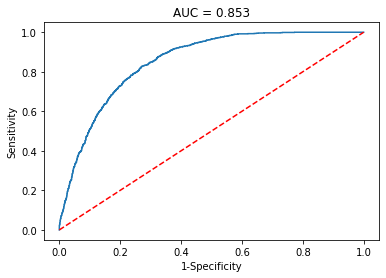

In [16]:
predictions = clf.predict_proba(validation.iloc[:,1:])

from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(np.asarray(validation_labels), predictions[:, 1])
auc = metrics.roc_auc_score(np.asarray(validation_labels), predictions[:, 1])
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("1-Specificity")
plt.ylabel("Sensitivity")
plt.title("AUC = {:.3f}".format(auc))
plt.savefig("../figures/relative_{}hr_lead_{}hr_obs/validation/roc.png".format(lead, obs))
plt.show()

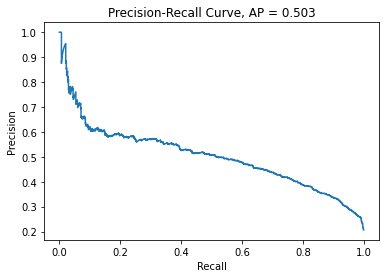

In [17]:
temp_precision, temp_recall, _ = metrics.precision_recall_curve(validation_labels, predictions[:, 1])
ap = metrics.average_precision_score(validation_labels, predictions[:, 1])
plt.figure()
plt.plot(temp_recall, temp_precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve, AP = {:.3f}".format(ap))
plt.savefig("../figures/relative_{}hr_lead_{}hr_obs/validation/precision_recall.png".format(lead, obs))
plt.show()

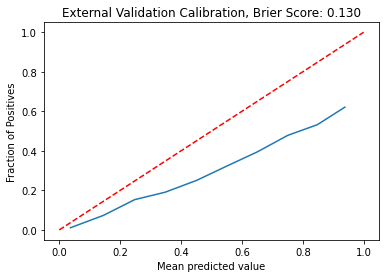

In [18]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

fraction_of_positives, mean_predicted_value = calibration_curve(validation_labels, predictions[:, 1], n_bins=10)
brier = brier_score_loss(validation_labels, predictions[:, 1])


plt.figure()
plt.plot(mean_predicted_value, fraction_of_positives)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("External Validation Calibration, Brier Score: {:.3f}".format(brier))
plt.savefig("../figures/relative_{}hr_lead_{}hr_obs/validation/calibration.png".format(lead, obs))
plt.show()


In [19]:
with open("../pickle/relative_{}hr_lead_{}hr_obs/validation/catboost_unpruned_results".format(lead, obs), "wb") as f:
    pickle.dump({"auc" : auc, "fpr" : fpr, "tpr" : tpr, "recall" : temp_recall, "precision" : temp_precision,
    "ap" : ap, "mean_predicted_value" : mean_predicted_value, "fraction_of_positives" : fraction_of_positives,
    "brier" : brier}, f)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


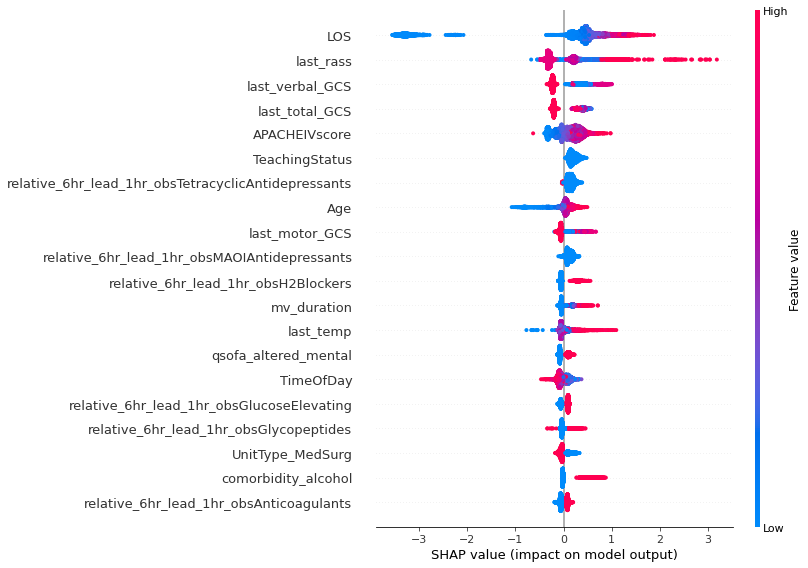

In [20]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(validation.iloc[:, 1:])
shap.summary_plot(shap_values, validation.iloc[:, 1:], show=False)
plt.savefig("../figures/relative_{}hr_lead_{}hr_obs/validation/shapley.png".format(lead, obs), bbox_inches="tight")

Trying to unpickle estimator LabelEncoder from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator _SigmoidCalibration from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator CalibratedClassifierCV from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


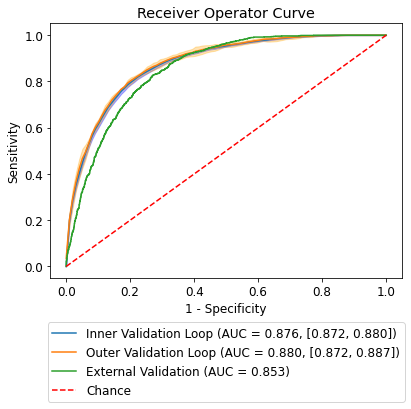

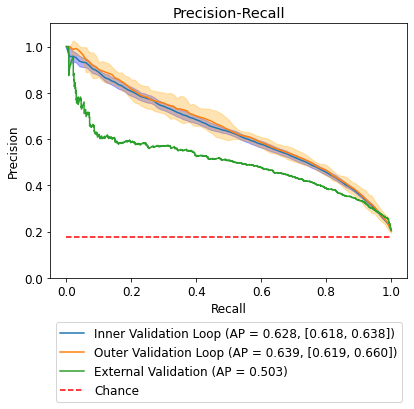

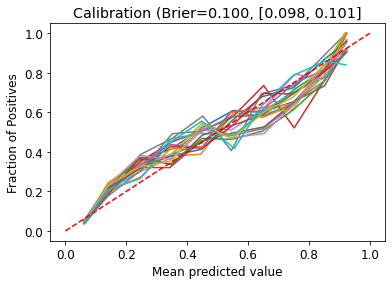

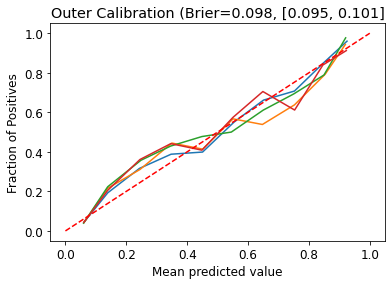

In [21]:
import pickle
with open("../pickle/relative_{}hr_lead_{}hr_obs/mean_unpruned/catboost_unbalanced".format(lead, obs), "rb") as f:
    catboost_result = pickle.load(f)
    

with open("../pickle/relative_{}hr_lead_{}hr_obs/mean_unpruned/pr_baseline".format(lead, obs), "rb") as f:
    pr_baseline = pickle.load(f)

result_dict = catboost_result
name = "/relative_{}hr_lead_{}hr_obs/validation/catboost".format(lead, obs)

base_fpr = np.linspace(0, 1, 100)

import matplotlib
matplotlib.rcParams.update({'font.size': 12})

# ROC's
inner_mid_tpr, inner_up_tpr, inner_low_tpr = compute_confidence(result_dict["itpr"])
inner_mid_auc, inner_up_auc, inner_low_auc = compute_confidence(result_dict["iauc"])
outer_mid_tpr, outer_up_tpr, outer_low_tpr = compute_confidence(result_dict["otpr"])
outer_mid_auc, outer_up_auc, outer_low_auc = compute_confidence(result_dict["oauc"])
training_mid_tpr, training_up_tpr, training_low_tpr = compute_confidence(result_dict["ttpr"])
training_mid_auc, training_up_auc, training_low_auc = compute_confidence(result_dict["tauc"])

plt.figure(figsize=(6,6))
plt.plot(base_fpr, inner_mid_tpr, base_fpr, outer_mid_tpr, fpr, tpr, [0, 1], [0, 1], 'r--')
plt.fill_between(base_fpr, inner_low_tpr, inner_up_tpr, color='blue', alpha=0.3)
plt.fill_between(base_fpr, outer_low_tpr, outer_up_tpr, color='orange', alpha=0.3)
plt.xlabel("1 - Specificity") 
plt.ylabel("Sensitivity")
plt.title("Receiver Operator Curve")
plt.legend(("Inner Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(inner_mid_auc, inner_low_auc, inner_up_auc),
    "Outer Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(outer_mid_auc, outer_low_auc, outer_up_auc),
    "External Validation (AUC = {0:.3f})".format(auc),
    'Chance'), loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.savefig("../figures/{}_ROC.png".format(name), dpi = 'figure')
plt.show()

mid_precision, up_precision, low_precision = compute_confidence(result_dict["ip"])
mid_ap, up_ap, low_ap = compute_confidence(result_dict["iap"])
base_recall = np.linspace(1,0,101)

outer_mid_precision, outer_up_precision, outer_low_precision = compute_confidence(result_dict["op"])
outer_mid_ap, outer_up_ap, outer_low_ap = compute_confidence(result_dict["oap"])


plt.figure(figsize=(6,6))
plt.plot(base_recall, mid_precision, base_recall, outer_mid_precision, temp_recall, temp_precision, [0, 1], [pr_baseline, pr_baseline], 'r--')
plt.fill_between(base_recall, low_precision, up_precision, color='blue', alpha=0.3)
plt.fill_between(base_recall, outer_low_precision, outer_up_precision, color='orange', alpha=0.3)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall")
plt.ylim([0,1.1])
plt.legend(("Inner Validation Loop (AP = {0:.3f}, [{1:.3f}, {2:.3f}])".format(mid_ap, low_ap, up_ap),
    "Outer Validation Loop (AP = {0:.3f}, [{1:.3f}, {2:.3f}])".format(outer_mid_ap, outer_low_ap, outer_up_ap),
    "External Validation (AP = {0:.3f})".format(ap),
    "Chance"),
    loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.savefig("../figures/{}_PR.png".format(name), dpi = 'figure')
plt.show()



mid_brier, up_brier, low_brier = compute_confidence(np.asarray(result_dict["ibrier"]))

plt.figure()
for i in range(len(result_dict["iprobtrue"])):
    plt.plot(result_dict["iprobpred"][i], result_dict["iprobtrue"][i])
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("Calibration (Brier={0:.3f}, [{1:.3f}, {2:.3f}]".format(mid_brier, low_brier, up_brier))
plt.savefig("../figures/{}_Calibration.png".format(name), dpi = 'figure')
plt.show()

mid_brier, up_brier, low_brier = compute_confidence(np.asarray(result_dict["obrier"]))

plt.figure()
for i in range(len(result_dict["oprobtrue"])):
    plt.plot(result_dict["oprobpred"][i], result_dict["oprobtrue"][i])
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("Outer Calibration (Brier={0:.3f}, [{1:.3f}, {2:.3f}]".format(mid_brier, low_brier, up_brier))
plt.savefig("../figures/{}_Calibration_outer.png".format(name), dpi = 'figure')
plt.show()

## CatBoost Pruned

In [22]:
from catboost import CatBoostClassifier
clf = CatBoostClassifier(**{"n_estimators": 3000})
clf.fit(data_pruned.iloc[:, 1:], labels)

ning: 11.7s
2629:	learn: 0.2195129	total: 1m 22s	remaining: 11.6s
2630:	learn: 0.2194805	total: 1m 22s	remaining: 11.6s
2631:	learn: 0.2194595	total: 1m 22s	remaining: 11.6s
2632:	learn: 0.2194308	total: 1m 22s	remaining: 11.5s
2633:	learn: 0.2193992	total: 1m 22s	remaining: 11.5s
2634:	learn: 0.2193564	total: 1m 22s	remaining: 11.5s
2635:	learn: 0.2193279	total: 1m 22s	remaining: 11.4s
2636:	learn: 0.2192973	total: 1m 22s	remaining: 11.4s
2637:	learn: 0.2192557	total: 1m 22s	remaining: 11.4s
2638:	learn: 0.2192289	total: 1m 22s	remaining: 11.4s
2639:	learn: 0.2191964	total: 1m 23s	remaining: 11.3s
2640:	learn: 0.2191713	total: 1m 23s	remaining: 11.3s
2641:	learn: 0.2191573	total: 1m 23s	remaining: 11.3s
2642:	learn: 0.2191343	total: 1m 23s	remaining: 11.2s
2643:	learn: 0.2191059	total: 1m 23s	remaining: 11.2s
2644:	learn: 0.2190783	total: 1m 23s	remaining: 11.2s
2645:	learn: 0.2190504	total: 1m 23s	remaining: 11.1s
2646:	learn: 0.2190148	total: 1m 23s	remaining: 11.1s
2647:	learn: 0.2

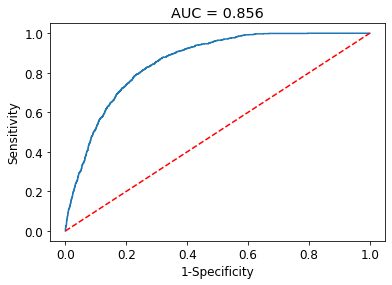

In [23]:
predictions = clf.predict_proba(validation_pruned.iloc[:,1:])

from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(np.asarray(validation_labels), predictions[:, 1])
auc = metrics.roc_auc_score(np.asarray(validation_labels), predictions[:, 1])
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("1-Specificity")
plt.ylabel("Sensitivity")
plt.title("AUC = {:.3f}".format(auc))
plt.savefig("../figures/relative_{}hr_lead_{}hr_obs/validation/pruned_roc.png".format(lead, obs))
plt.show()

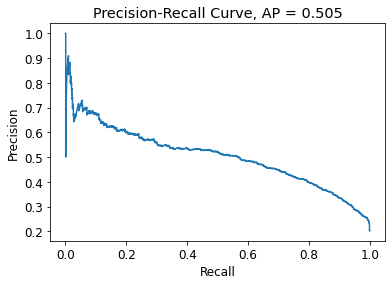

In [24]:
temp_precision, temp_recall, _ = metrics.precision_recall_curve(validation_labels, predictions[:, 1])
ap = metrics.average_precision_score(validation_labels, predictions[:, 1])
plt.figure()
plt.plot(temp_recall, temp_precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve, AP = {:.3f}".format(ap))
plt.savefig("../figures/relative_{}hr_lead_{}hr_obs/validation/pruned_precision_recall.png".format(lead, obs))
plt.show()

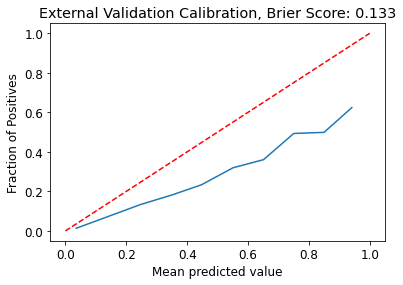

In [25]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

fraction_of_positives, mean_predicted_value = calibration_curve(validation_labels, predictions[:, 1], n_bins=10)
brier = brier_score_loss(validation_labels, predictions[:, 1])


plt.figure()
plt.plot(mean_predicted_value, fraction_of_positives)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("External Validation Calibration, Brier Score: {:.3f}".format(brier))
plt.savefig("../figures/relative_{}hr_lead_{}hr_obs/validation/pruned_calibration.png".format(lead, obs))
plt.show()


In [26]:
with open("../pickle/relative_{}hr_lead_{}hr_obs/validation/catboost_pruned_results".format(lead, obs), "wb") as f:
    pickle.dump({"auc" : auc, "fpr" : fpr, "tpr" : tpr, "recall" : temp_recall, "precision" : temp_precision,
    "ap" : ap, "mean_predicted_value" : mean_predicted_value, "fraction_of_positives" : fraction_of_positives,
    "brier" : brier}, f)

Trying to unpickle estimator LabelEncoder from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator _SigmoidCalibration from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator CalibratedClassifierCV from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


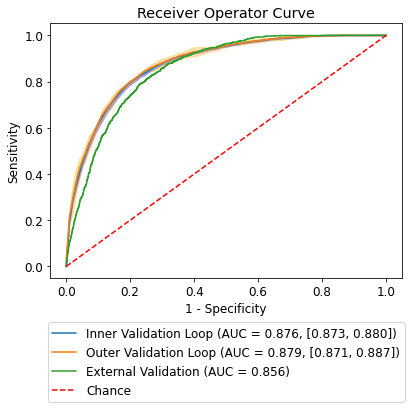

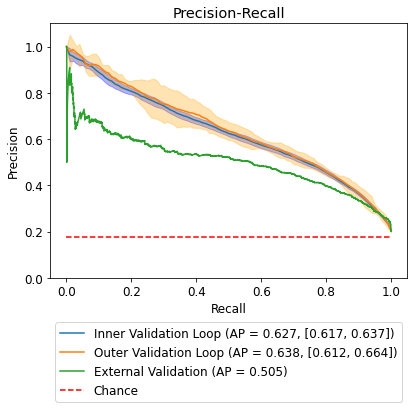

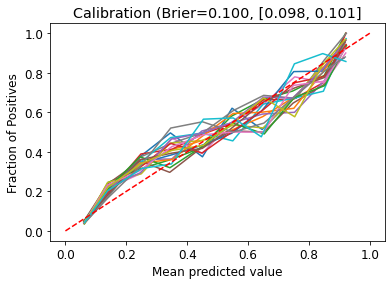

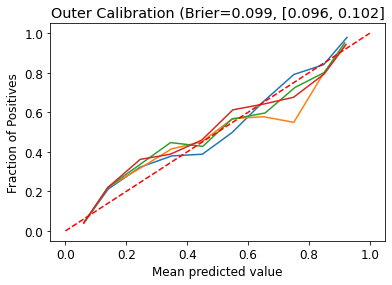

In [27]:
import pickle
with open("../pickle/relative_{}hr_lead_{}hr_obs/mean_pruned/catboost_unbalanced".format(lead, obs), "rb") as f:
    catboost_result = pickle.load(f)
    

with open("../pickle/relative_{}hr_lead_{}hr_obs/mean_unpruned/pr_baseline".format(lead, obs), "rb") as f:
    pr_baseline = pickle.load(f)

result_dict = catboost_result
name = "/relative_{}hr_lead_{}hr_obs/validation/catboost_pruned".format(lead, obs)

base_fpr = np.linspace(0, 1, 100)

import matplotlib
matplotlib.rcParams.update({'font.size': 12})

# ROC's
inner_mid_tpr, inner_up_tpr, inner_low_tpr = compute_confidence(result_dict["itpr"])
inner_mid_auc, inner_up_auc, inner_low_auc = compute_confidence(result_dict["iauc"])
outer_mid_tpr, outer_up_tpr, outer_low_tpr = compute_confidence(result_dict["otpr"])
outer_mid_auc, outer_up_auc, outer_low_auc = compute_confidence(result_dict["oauc"])
training_mid_tpr, training_up_tpr, training_low_tpr = compute_confidence(result_dict["ttpr"])
training_mid_auc, training_up_auc, training_low_auc = compute_confidence(result_dict["tauc"])

plt.figure(figsize=(6,6))
plt.plot(base_fpr, inner_mid_tpr, base_fpr, outer_mid_tpr, fpr, tpr, [0, 1], [0, 1], 'r--')
plt.fill_between(base_fpr, inner_low_tpr, inner_up_tpr, color='blue', alpha=0.3)
plt.fill_between(base_fpr, outer_low_tpr, outer_up_tpr, color='orange', alpha=0.3)
plt.xlabel("1 - Specificity") 
plt.ylabel("Sensitivity")
plt.title("Receiver Operator Curve")
plt.legend(("Inner Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(inner_mid_auc, inner_low_auc, inner_up_auc),
    "Outer Validation Loop (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(outer_mid_auc, outer_low_auc, outer_up_auc),
    "External Validation (AUC = {0:.3f})".format(auc),
    'Chance'), loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.savefig("../figures/{}_ROC.png".format(name), dpi = 'figure')
plt.show()

mid_precision, up_precision, low_precision = compute_confidence(result_dict["ip"])
mid_ap, up_ap, low_ap = compute_confidence(result_dict["iap"])
base_recall = np.linspace(1,0,101)

outer_mid_precision, outer_up_precision, outer_low_precision = compute_confidence(result_dict["op"])
outer_mid_ap, outer_up_ap, outer_low_ap = compute_confidence(result_dict["oap"])


plt.figure(figsize=(6,6))
plt.plot(base_recall, mid_precision, base_recall, outer_mid_precision, temp_recall, temp_precision, [0, 1], [pr_baseline, pr_baseline], 'r--')
plt.fill_between(base_recall, low_precision, up_precision, color='blue', alpha=0.3)
plt.fill_between(base_recall, outer_low_precision, outer_up_precision, color='orange', alpha=0.3)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall")
plt.ylim([0,1.1])
plt.legend(("Inner Validation Loop (AP = {0:.3f}, [{1:.3f}, {2:.3f}])".format(mid_ap, low_ap, up_ap),
    "Outer Validation Loop (AP = {0:.3f}, [{1:.3f}, {2:.3f}])".format(outer_mid_ap, outer_low_ap, outer_up_ap),
    "External Validation (AP = {0:.3f})".format(ap),
    "Chance"),
    loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.savefig("../figures/{}_PR.png".format(name), dpi = 'figure')
plt.show()



mid_brier, up_brier, low_brier = compute_confidence(np.asarray(result_dict["ibrier"]))

plt.figure()
for i in range(len(result_dict["iprobtrue"])):
    plt.plot(result_dict["iprobpred"][i], result_dict["iprobtrue"][i])
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("Calibration (Brier={0:.3f}, [{1:.3f}, {2:.3f}]".format(mid_brier, low_brier, up_brier))
plt.savefig("../figures/{}_Calibration.png".format(name), dpi = 'figure')
plt.show()

mid_brier, up_brier, low_brier = compute_confidence(np.asarray(result_dict["obrier"]))

plt.figure()
for i in range(len(result_dict["oprobtrue"])):
    plt.plot(result_dict["oprobpred"][i], result_dict["oprobtrue"][i])
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("Outer Calibration (Brier={0:.3f}, [{1:.3f}, {2:.3f}]".format(mid_brier, low_brier, up_brier))
plt.savefig("../figures/{}_Calibration_outer.png".format(name), dpi = 'figure')
plt.show()